# Day 08. Exercise 00
# Binary classifier. Logistic regression

## 0. Imports

In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 1. Preprocessing

- Get the data from the file `checker-timestamp.csv`.


- Create a dataframe `df` with the columns: `date`, `am`, `pm`, `target`, where `date` is the date of the day, `am` is the number of the commits during the day before midday (integer), `pm` is the number of commits during the day after midday (integer), `target` is weekend/working_day.

In [30]:
df = pd.read_csv('../data/checker_timestamp.csv', parse_dates=['timestamp'])
df['date'] = df['timestamp'].dt.date
df['time_label'] = df['timestamp'].apply(lambda x: 'am' if x.hour < 12 else 'pm')
df_dates = pd.DataFrame(df['date'].unique(), columns=['date'])
df_am = df[df['time_label'] == 'am'].groupby(['date']).size().to_frame('am').reset_index()
df_pm = df[df['time_label'] == 'pm'].groupby(['date']).size().to_frame('pm').reset_index()
df = pd.merge(df_dates, df_am, on='date', how='left')
df = pd.merge(df, df_pm, on='date', how='left')
df['date'] = pd.to_datetime(df['date'])
df['target'] = df['date'].dt.dayofweek.apply(lambda dw: 'weekend' if dw in [5, 6] else 'working_day')
df.head()
df = df.fillna(0)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    35 non-null     datetime64[ns]
 1   am      35 non-null     float64       
 2   pm      35 non-null     float64       
 3   target  35 non-null     object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.2+ KB


,date,am,pm,target
0,2020-04-17,21.0,2.0,working_day
1,2020-04-18,1.0,68.0,weekend
2,2020-04-19,18.0,15.0,weekend
3,2020-04-20,2.0,23.0,working_day
4,2020-04-21,0.0,25.0,working_day
5,2020-04-22,0.0,28.0,working_day
6,2020-04-23,10.0,33.0,working_day
7,2020-04-24,2.0,14.0,working_day
8,2020-04-25,30.0,74.0,weekend
9,2020-04-26,28.0,233.0,weekend


## 2. Exploratory analysis

- Create a plot where `x` is am, `y` is pm, each dot is a day, working days and weekends must have different colors.


- By looking at the graph do you think it will be easy to classify the days having those two features? Put your answer in the markdown cell in the end of that sectioin: "yes, it is easy" or "no, it is not easy".

<Axes: xlabel='am', ylabel='pm'>

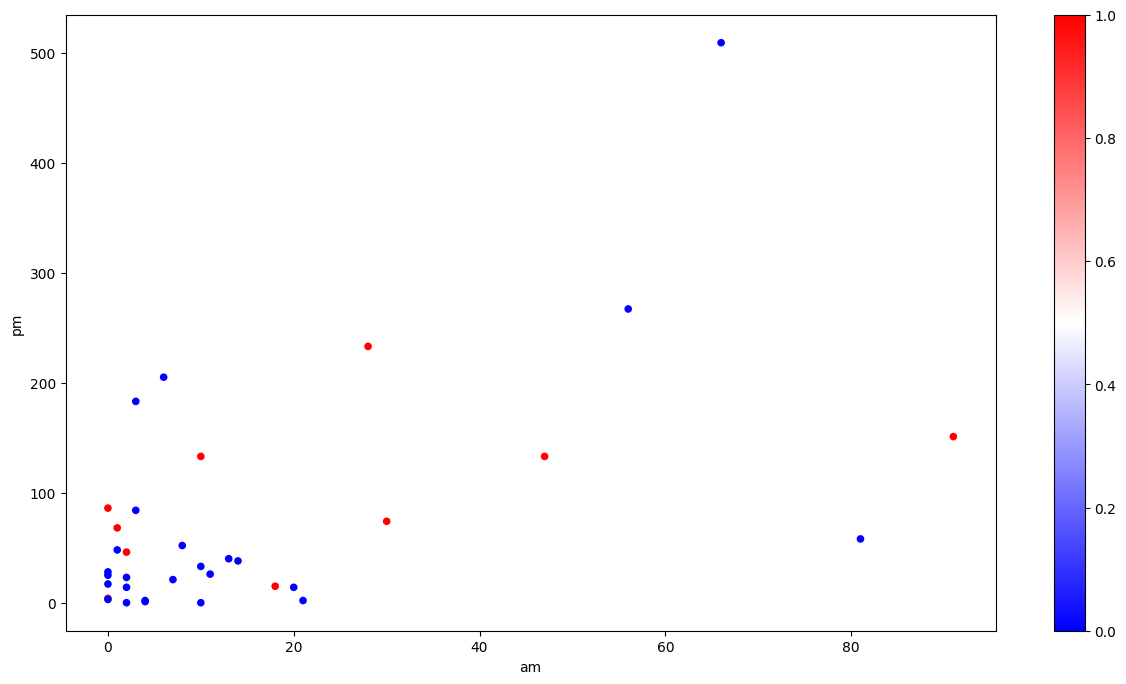

In [20]:
colors = df['target'].map({'working_day': 0, 'weekend': 1})
df.plot(kind='scatter', x='am', y='pm', figsize=(15,8), c=colors, cmap='bwr')

Yes, kinda easy. At least for human.

## 3. Logistic regression

- Train logistic regression on your data using `am` and `pm`, parameters are: `random state=21`, `fit_intercept=False`.


- Make predictions for every day of your dataset and add them to your dataframe with the column name `predict`.


- Save the dataframe into a file in the subfolder of the day `data` with the name `am_pm.csv`.


- Draw another plot like you did before, but the color should be taken from the `predict`.


- By looking at the graph do you think if it made good predictions? Put your answer in the markdown cell in the end of that section: "yes, it is good"; "no, it is not good".

In [21]:
model = LogisticRegression(random_state=21, fit_intercept=False)
X = df[['am', 'pm']]
y = df['target'].astype('category')
model.fit(X=X, y=y)
df['predict'] = model.predict(X)

<Axes: xlabel='am', ylabel='pm'>

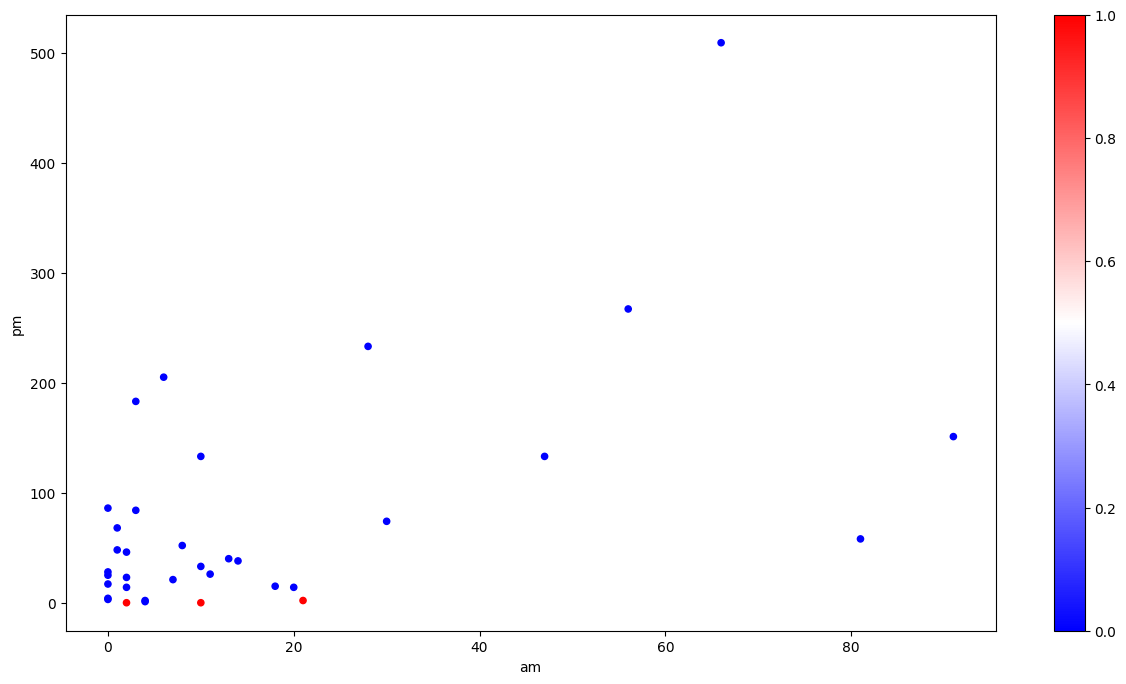

In [22]:
colors = df['predict'].map({'working_day': 0, 'weekend': 1})
df.plot(kind='scatter', x='am', y='pm', figsize=(15,8), c=colors, cmap='bwr')

Well, that was BAD

Well, maybe we can improve it?

In [23]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [24]:
model.fit(X=X_poly, y=y)
pred = pd.Series(model.predict(X_poly))

<Axes: xlabel='am', ylabel='pm'>

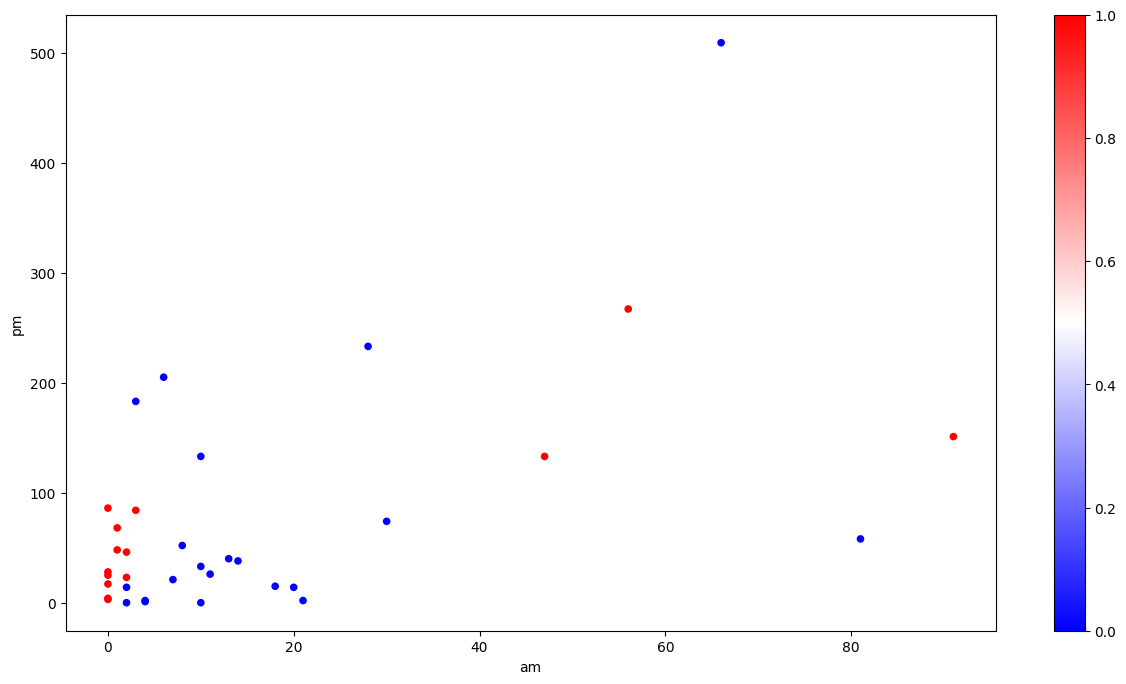

In [25]:
colors = pred.map({'working_day': 0, 'weekend': 1})
df.plot(kind='scatter', x='am', y='pm', figsize=(15,8), c=colors, cmap='bwr')

Fiasco. Doesn't look any better

## 4. Evaluation

- Calculate `accuracy` for your predictions.


- Calculate `accuracy` for the naive case when each of your prediction is the value of your most popular class of the day.


- Comparing the accuracies do you think that the classifier made good predictions? Put your answer in the markdown cell in the end of the secion: "yes, it is good"; "no, it is not good".

In [26]:
accuracy_score(y, df['predict'])

0.6285714285714286

In [27]:
accuracy_score(y, pred)

0.6571428571428571

Though poly kinda made it better

In [28]:
accuracy_score(y, df['target'].apply(df['target'].mode))

0.7142857142857143

But not good enough. Yeah, that was very, very BAD. Bad moddel, bad

In [29]:
df.to_csv('../data/am_pm.csv', index=False)